In [230]:
%load_ext autoreload
%autoreload 2

import os
import struct
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import gfft

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note, GFFT only works on Python 2

In [231]:
FNAME = '/project/druhe/SB320-202012281240-lba_outer.vis'

MAGIC = '0x000000003B98F002'
int(MAGIC, 0)


999878658

In [232]:
NANT = 576
SUB = 320
NCHAN = 1
POL2REC = 4
LEN_HDR = 512
NBLINE = NANT * (NANT + 1) // 2
PAYLOAD = NBLINE * NCHAN * POL2REC * 8# Final *2 unknown
RECSIZE = PAYLOAD + LEN_HDR

fsize = os.path.getsize(FNAME)
nrec = fsize // RECSIZE
nrec

418

In [233]:
def read_vis(f):
    s = f.read(RECSIZE)

    header = s[:512]
    data = s[512:]

    magic, = struct.unpack("<Q", s[0:8])
    magic = np.uint32(magic)
    assert int(magic) == int(MAGIC, 0)
    
    data = np.reshape(np.frombuffer(data, dtype=np.complex64), (NBLINE, NCHAN, POL2REC))
    return data

In [234]:
# xx, xy, yx, yy
with open(FNAME, 'rb') as f:
    
    f.seek(0 * RECSIZE)

    vis = read_vis(f)
data = vis.copy()    
data.shape


(166176, 1, 4)

In [235]:
from parse_lba_antennafield import parse_lba_antennafield
L = parse_lba_antennafield('../antennafields/a12-AntennaField.conf', [SUB])

In [236]:
from scipy.constants import c
meters_to_wavelengths = 2 * SUB * 2e8 / (1024  * c)  # frequency over speed is wavelength

In [237]:
L_2d = L[:, :2]
distances = meters_to_wavelengths * (L_2d[:, None] - L_2d)

Text(0.5,1,'Antenna locations A12')

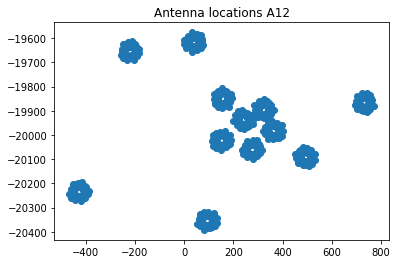

In [238]:
plt.figure(figsize=np.array([6, 4]), facecolor='white')
plt.scatter(L_2d[:, 0], L_2d[:, 1])
plt.title('Antenna locations A12')

Text(0.5,1,'UV coverage A12')

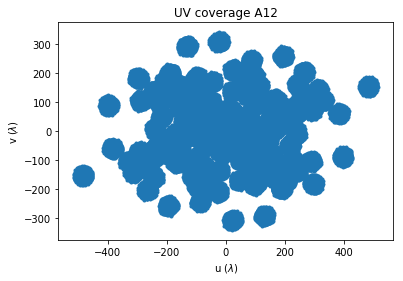

In [239]:
plt.figure(figsize=np.array([6, 4]), facecolor='white')
distances_no_auto = distances[~np.eye(len(distances), dtype=bool)]
plt.scatter(distances_no_auto[:, 0], distances_no_auto[:, 1], marker='.')
plt.xlabel(r'u ($\lambda$)')
plt.ylabel(r'v ($\lambda$)')
plt.title('UV coverage A12')

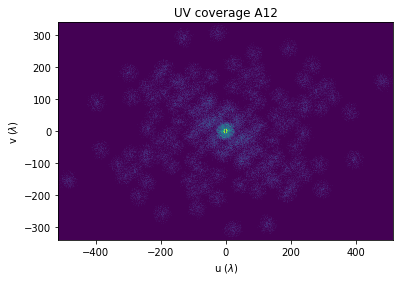

In [240]:
plt.figure(figsize=np.array([6, 4]) * 1, facecolor='white')
plt.hist2d(distances_no_auto[:, 0], distances_no_auto[:, 1], bins=750)
plt.xlabel(r'u ($\lambda$)')
plt.ylabel(r'v ($\lambda$)')
plt.title('UV coverage A12')
plt.show()

In [246]:
# Change to diagonal correlation matrix to view which baselines are bad.

covar_matrix = np.full([576, 576], 0j)
covar_matrix[np.tril_indices_from(covar_matrix)] = data[:, 0, 0]
covar_matrix = covar_matrix + covar_matrix.T - 2 * np.eye(576) * covar_matrix

Text(0.5,1,'SB320-202012281240-lba_outer.vis covariance matrix')

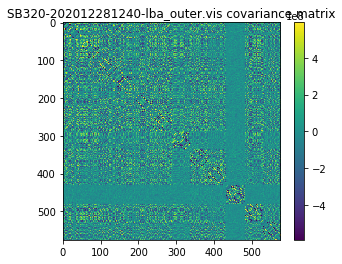

In [247]:
import seaborn as sns
from matplotlib.colors import LogNorm

# sns.set_context('notebook')
# sns.set_style('whitegrid')
plt.figure(facecolor='white')
plt.imshow(np.real(covar_matrix), 
           vmin=np.real(covar_matrix).mean() - 3 * np.real(covar_matrix).std(), 
           vmax=np.real(covar_matrix).mean() + 3 * np.real(covar_matrix).std())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SB320-202012281240-lba_outer.vis covariance matrix')

In [248]:
covar_matrix_full = np.concatenate([distances, covar_matrix[..., None]], axis=-1)

covar_no_auto = covar_matrix_full[~np.eye(len(covar_matrix_full), dtype=bool)]

/home/druhe/projects/interferometry/.venv_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


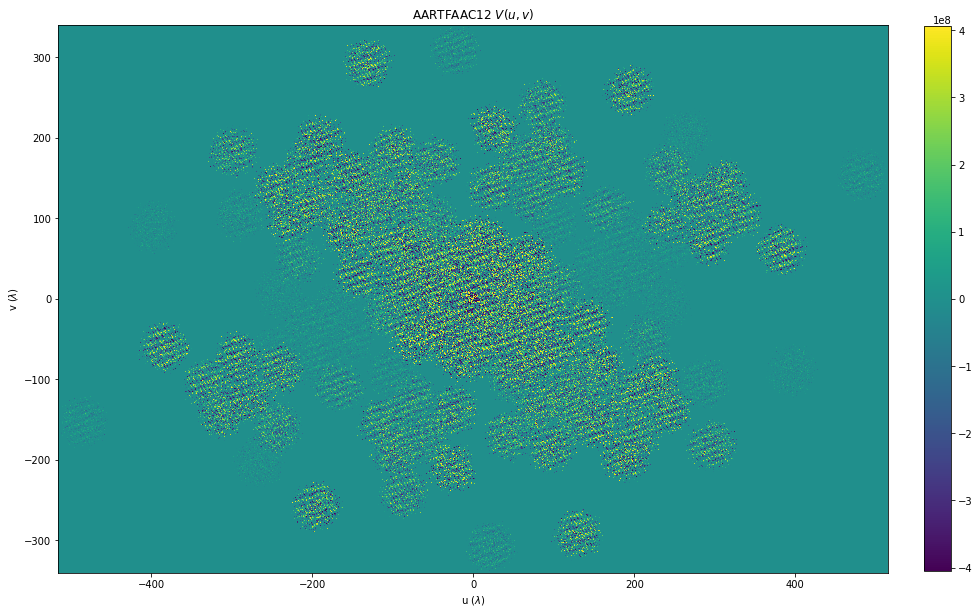

In [249]:
uv_indices = covar_no_auto[:, :2].copy()
uv_indices[:, 0] = uv_indices[:, 0] - uv_indices[:, 0].min()
uv_indices[:, 1] = uv_indices[:, 1] - uv_indices[:, 1].min()
uv_indices = uv_indices.astype(int)

V = np.zeros([uv_indices[:, 1].max().astype(int) + 1, uv_indices[:, 0].max().astype(int) + 1], dtype=complex)

V[uv_indices[:, 1], uv_indices[:, 0]] = covar_no_auto[:, 2].real
plt.figure(figsize=np.array([4, 6]) * 4, facecolor='white')
plt.imshow(V.real, 
           vmin=V.real.mean() - 5 * V.real.std(), 
           vmax=V.real.mean() + 5 * V.real.std(),
           extent=[-V.shape[1]/2., V.shape[1]/2., -V.shape[0]/2., V.shape[0]/2.],
           origin='lower'
          )
plt.title(r'AARTFAAC12 $V(u, v)$')
plt.ylabel(r'v $(\lambda)$')
plt.xlabel(r'u $(\lambda)$')
plt.colorbar(fraction=0.0305, pad=0.04)


In [250]:
res = 2300
dx = 1.0 / res
out_ax = [(dx, res), (dx, res)]
 

In [251]:
L = np.linspace(-1, 1, res)
M = np.linspace(-1, 1, res) 
mask = np.ones((res, res))
xv, yv = np.meshgrid(L, M)

In [252]:
image = data.copy()

In [253]:
u, v = distances[np.tril_indices(576)].T


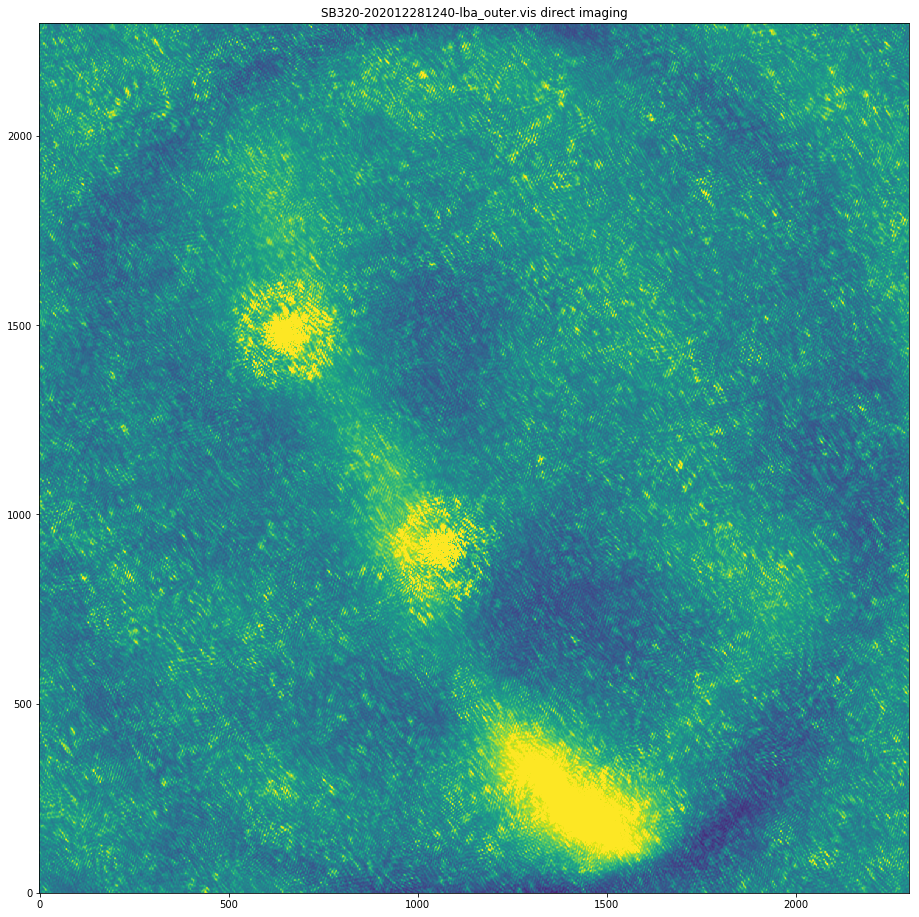

In [254]:
# XX, XY, YX, YY
im = image.mean(axis=(-1, -2))


im = np.rot90(np.real(gfft.gfft(np.ravel(im), [u, v], out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask


plt.figure(figsize=(16, 16), facecolor='white')
plt.imshow(im, vmin=np.nanmean(im) - 3 * np.nanstd(im), vmax=np.nanmean(im) + 3 * np.nanstd(im), origin='lower')
plt.title('SB320-202012281240-lba_outer.vis direct imaging')
plt.show()

